In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch import nn

print(torch.__version__)

2.0.0+cu118


In [3]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Mon May  8 07:15:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get data
Food101 datasets

In [5]:
import requests
import zipfile
from pathlib import Path

# Set up path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_file():
    print(f"{image_path} is exist and skipping download...")
else:
    image_path.mkdir(parents=True, 
                     exist_ok=True)
    
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloding pizza_steak_sushi.zip....")
    f.write(request.content)
    
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza_steak_sushi.zip data ....")
    zip_ref.extractall(image_path)


Downloding pizza_steak_sushi.zip....
Unzipping pizza_steak_sushi.zip data ....


In [6]:
image_path

PosixPath('data/pizza_steak_sushi')

In [7]:
!ls data/pizza_steak_sushi/test

pizza  steak  sushi


## 2. Becomming one with the data

In [8]:
import os 
def walk_through_dir(dir_path):
    
    """Walks through di_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [9]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [10]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
print(train_dir)
print(test_dir)

data/pizza_steak_sushi/train
data/pizza_steak_sushi/test


## 2.1 Visualizing and image

data/pizza_steak_sushi/test/steak/3873283.jpg
steak
Random image path : data/pizza_steak_sushi/test/steak/3873283.jpg
Image class: steak
Image height: 512
Image width: 512


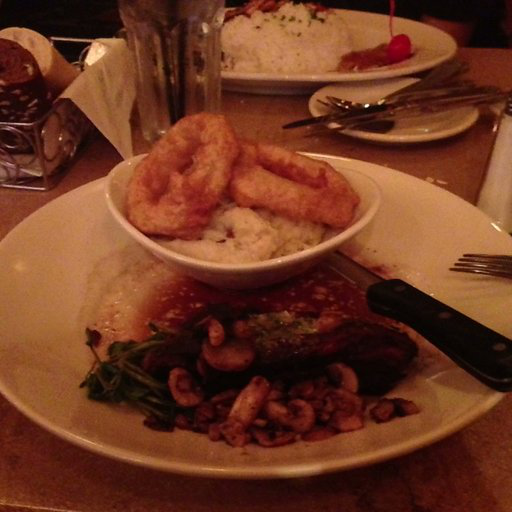

In [11]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# print(image_path_list)

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. open image 
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path : {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

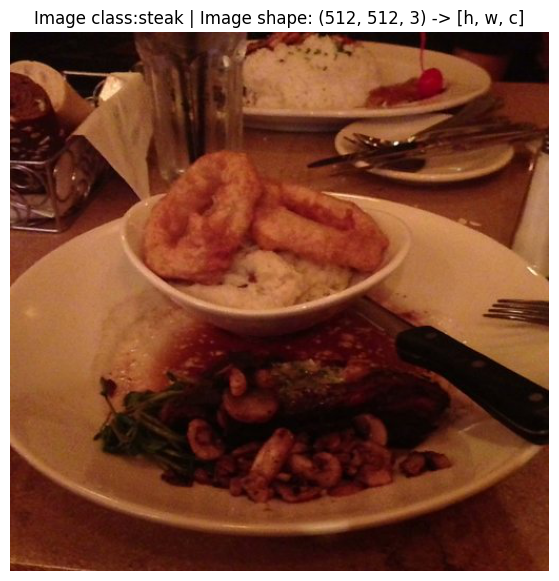

In [12]:
import numpy as np
import matplotlib.pyplot as plt


img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class:{image_class} | Image shape: {img_as_array.shape} -> [h, w, c]")
plt.axis("off")

## 3. transforming Data
1. turn data to tensor
2. Turn it into a `torh.utils.data.Dataset` and `torch.utils.data.DataLoader`


In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with `torchvision.transform`

In [14]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [15]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

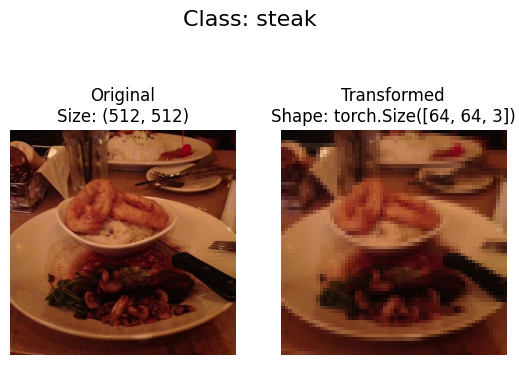

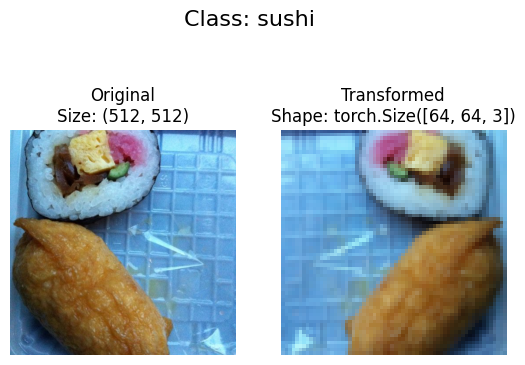

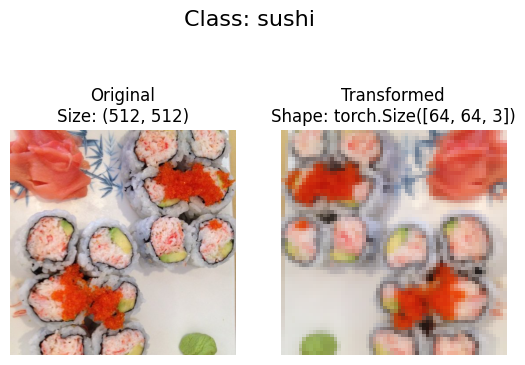

In [16]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n=3,
                            seed=42):
  """Selects random images from path and transforms it and plots them"""
  if seed: 
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")
      
      
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)
  

## 4. Option 1: Loading image data using `torchvision.datasets.ImageFolder`

In [17]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
# Get class name as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
# Get class names as dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
# Check the length
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [22]:
# Index on the train_data Dataset to get a single and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Originl shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

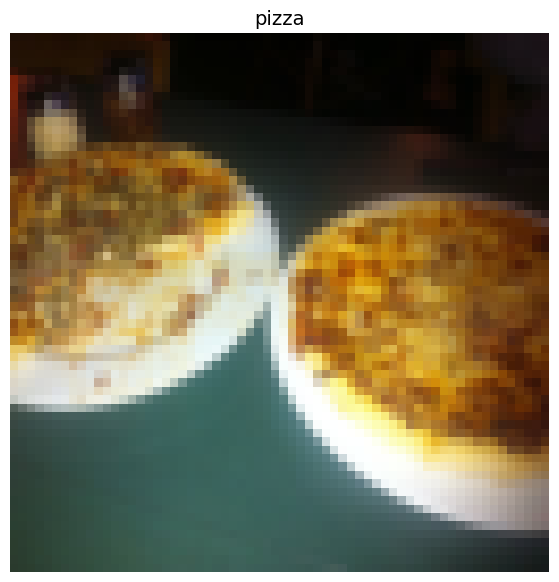

In [23]:
img_permute = img.permute(1, 2, 0)

print(f"Originl shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded images in to `DataLoader`'s

In [24]:
!nvidia-smi

Mon May  8 07:15:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
os.cpu_count()

2

In [26]:
# turn train and test datasets to DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
 
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f5be221d5d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5be229ab30>)

In [27]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [28]:
img , label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [b, c, h, w]")
print(f"label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [b, c, h, w]
label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a custom `Dataset`
1. Load imgaes from file
2. get class names from the Dataset
3. get classes as dictionary from Dataset


In [29]:
import os 
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [30]:
# Instancr of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

fuction to:
1. Get class names using `os.scandir()`
2. Raise an error if class names aren't found
3. Turn the class name to dict and list

In [31]:
target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [32]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the class folder names in a target directory
  """
  # 1.
  classes =sorted(entry.name for entry in list(os.scandir(directory)) if entry.inode())
  # 2.
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}....plese check file structure.")

  # 3.
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx


In [33]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`
1. Subclass torch.utils.data.Dataset.
2. Init our subclass with a target directory as we as a transform.
3. Create several attributes:
  * paths
  * transform
  * classes
  * class_to_idx

4. Create a function to `load_image()`
5. Overwrite the `__len__()`
6. Overwrite the `__getitem__()`


In [34]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset

class ImageFolderCustom(Dataset):
  # 2.
  def __init__(self, 
               targ_dir: str, 
               transform=None):
    # 3.
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)


  # 4.
  def load_image(self, index:int) -> Image.Image:
    """ Opens an image via a path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)


  # 5. optional overwritw __len__()
  def __len__(self)->int:
    """Returns the total number of samples."""
    return len(self.paths)

  # 6. Must overwrite __getitem__()

  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
     """ Returns one sample of data, data and label (X,y)"""
     img = self.load_image(index)
     class_name = self.paths[index].parent.name
     class_idx = self.class_to_idx[class_name]

     if self.transform:
        return self.transform(img), class_idx

     else:
        return img, class_idx



In [35]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [36]:
train_data_custom = ImageFolderCustom(
    targ_dir=train_dir,
    transform=train_transform,
    )

test_data_custom = ImageFolderCustom(
    targ_dir = test_dir,
    transform= test_transforms
)

In [37]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f5be20ba200>,
 <__main__.ImageFolderCustom at 0x7f5be20ba0b0>)

In [38]:
len(train_data), len(train_data_custom)

(225, 225)

In [39]:
len(test_data), len(test_data_custom)

(75, 75)

In [40]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [41]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}


### 5.3 Create a function to display random images


In [42]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

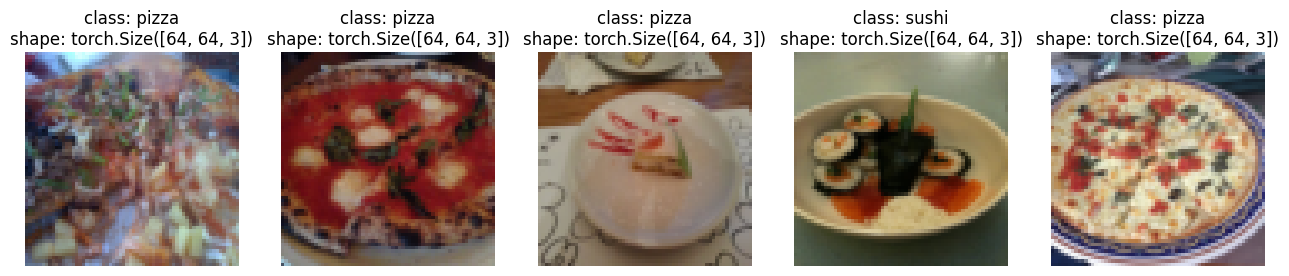

In [43]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


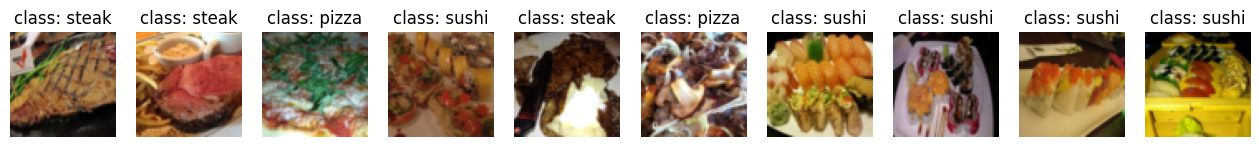

In [44]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

### 5.4 Turn custom loaded images into DataLoader'

In [45]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f5be1633280>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5be11c1180>)

In [46]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

In [47]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

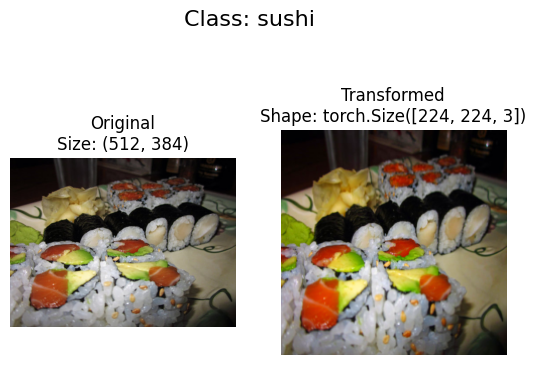

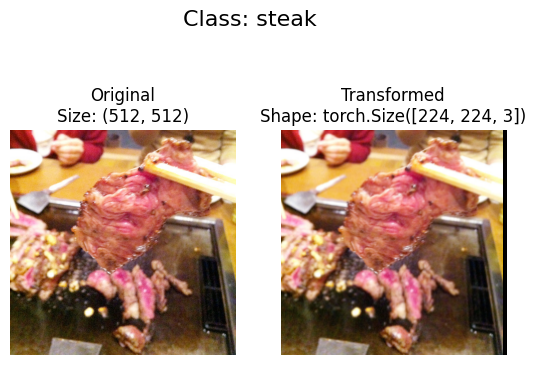

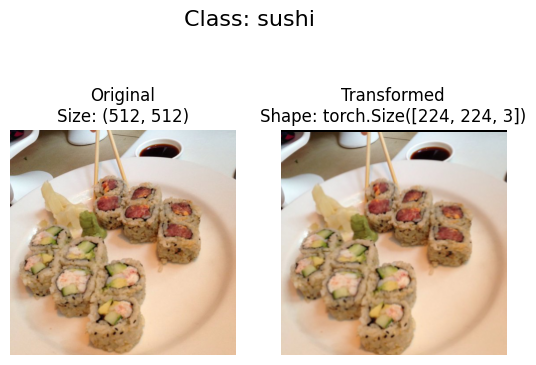

In [48]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)


## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transformss an loading data for Model 0

In [49]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [50]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform) 



In [51]:
import os 
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

### 7.2 Create TinyVGG

In [52]:
from numpy.ma.core import shape
class TinyVGG(nn.Module):
  def __init__(self,
                input_shape: int,
               hidden_units: int,
                output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),


        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),


        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2,
                     stride=2)
        
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units* 13 * 13,
                  out_features=output_shape)
    )

  def forward(self, x):
    z = self.conv_block_1(x)
    # print(z.shape)

    z = self.conv_block_2(z)
    # print(z.shape)

    z = self.classifier(z)
    # print(z.shape)

    return z
        


In [53]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=3).to(device)


model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on single image (to test the model)

In [54]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [55]:
image_batch.dtype, label_batch.dtype

(torch.float32, torch.int64)

In [56]:
model_0(image_batch.to(device)).to(device)

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1837e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4218e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8272e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shape going through our model

In [57]:
try: 
  import torchinfo

except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train & test loop functions


In [58]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc